Here the goal is to find the detect fraudulent credit/debit card transactions.Everything except the time and amount has been reduced by a Principle Component Analysis (PCA) for privacy concerns.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 


In [12]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


visualize the data to investigate the frequency of the normal and fraudulent ones

Text(0.5, 1.0, 'Frequency by observation number')

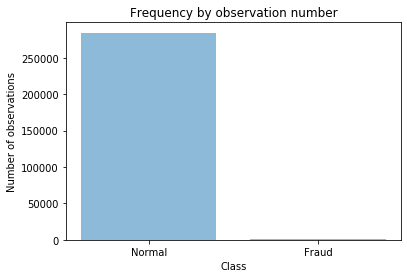

In [13]:
plt.bar(['Normal', 'Fraud'], df['Class'].value_counts(), align='center', alpha=0.5)
plt.xlabel('Class')
plt.ylabel('Number of observations')
plt.title('Frequency by observation number')

Split data to normal and fraudulent

In [0]:
normal_df = df.loc[df['Class']==0]
fraud_df = df.loc[df['Class']==1]


In [15]:
normal_df.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Normalize the data and generate train and test datasets

In [0]:
# normalize the 'Amount' column
from sklearn.preprocessing import StandardScaler
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df = df.drop(['Time'], axis=1)

In [17]:
# separate data/result and train/test datasets
X = df.iloc[:, df.columns != 'Class']
y = df.iloc[:, df.columns == 'Class']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(227845, 29)
(56962, 29)
(227845, 1)
(56962, 1)


Generate the auto-encoder model

In [18]:
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

input_dim = X_train.shape[1]
encoding_dim = 15
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

Fit the model

In [19]:
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history





Train on 227845 samples, validate on 56962 samples







Epoch 1/100
227845/227845 [==============================] - 11s 47us/step - loss: 0.8631 - acc: 0.5616 - val_loss: 0.8298 - val_acc: 0.6092

Epoch 2/100
227845/227845 [==============================] - 10s 46us/step - loss: 0.7976 - acc: 0.6185 - val_loss: 0.7991 - val_acc: 0.6461
Epoch 3/100
227845/227845 [==============================] - 10s 44us/step - loss: 0.7741 - acc: 0.6516 - val_loss: 0.7910 - val_acc: 0.6539
Epoch 4/100
227845/227845 [==============================] - 10s 44us/step - loss: 0.7678 - acc: 0.6579 - val_loss: 0.7846 - val_acc: 0.6576
Epoch 5/100
227845/227845 [==============================] - 10s 44us/step - loss: 0.7633 - acc: 0.6634 - val_loss: 0.7816 - val_acc: 0.6676
Epoch 6/100
227845/227845 [==============================] - 10s 44us/step - loss: 0.7603 - acc: 0.6687 - val_loss: 0.7787 - val_acc: 0.6700
Epoch 7/100
227845/227845 [==============================] - 10s 44us/step - loss: 0.7584 -

Plot loss vs epochs for train and validation

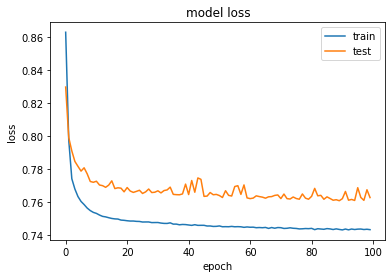

In [20]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

Predict the test data

In [49]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

error_df = pd.DataFrame({'reconstruction_error': mse,
                         'true_class': y_test.Class})
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.756456,0.001773
std,7.487146,0.042071
min,0.035091,0.000000
25%,0.244331,0.000000
50%,0.397754,0.000000
75%,0.636458,0.000000
max,1582.086103,1.000000


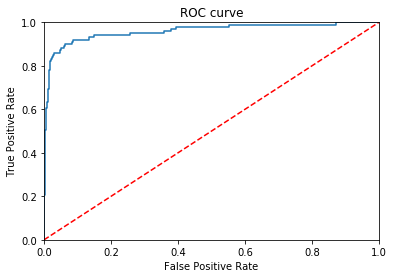

In [51]:
# plot the ROC curve
from sklearn.metrics import auc, roc_curve

fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)

plt.title('ROC curve')
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();